In [6]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error


In [9]:
# Load the CSV file with proper column names and skip footer
try:
    # data = pd.read_csv(r"C:\Users\ishwa\Downloads\co2_mm_mlo.csv", header=None,
    #                    names=['year', 'month', 'decimal_date', 'average', 'deseasonalized', 'ndays', 'sdev', 'unc'],
    #                    skiprows=72, engine='python', skipfooter=3)
    
    data = pd.read_csv("https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.csv", header=None,
                       names=['year', 'month', 'decimal_date', 'average', 'deseasonalized', 'ndays', 'sdev', 'unc'],
                       skiprows=72, engine='python', skipfooter=3)
    print(data.head())
except pd.errors.ParserError:
    print("Error parsing CSV file.")

# Convert 'average' column to numeric, coercing errors to NaN
data['average'] = pd.to_numeric(data['average'], errors='coerce')

# Drop rows with NaN values in 'average' column
data.dropna(subset=['average'], inplace=True)


   year  month  decimal_date  average  deseasonalized  ndays  sdev   unc
0  1960     10     1960.7896   313.83          316.83     -1 -9.99 -0.99
1  1960     11     1960.8743   315.00          316.88     -1 -9.99 -0.99
2  1960     12     1960.9563   316.19          316.96     -1 -9.99 -0.99
3  1961      1     1961.0411   316.89          316.86     -1 -9.99 -0.99
4  1961      2     1961.1260   317.70          317.08     -1 -9.99 -0.99


In [11]:
# Define MA function
def moving_average_forecast(data, k, t):
    forecast = data['average'].iloc[-k:].mean()  # Simple moving average
    return np.repeat(forecast, t)

# Define ARMA function

def arma_forecast_fn(data, p, q, t):
    model = ARIMA(data['average'], order=(p, 0, q))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=t)
    return forecast


In [15]:
# Split data into training and testing sets
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

# Parameters
K = 3  # Previous K readings
T = 1  # Predict next T reading
P = 1  # Autoregressive order for ARMA model
Q = 1  # Moving average order for ARMA model



In [16]:
# Perform MA and ARMA forecasting
ma_forecast = moving_average_forecast(data, K, len(test_data))
arma_forecast = arma_forecast_fn(train_data, P, Q, len(test_data))

# Calculate MAE for MA and ARMA
mae_ma = mean_absolute_error(test_data['average'], ma_forecast)
mae_arma = mean_absolute_error(test_data['average'], arma_forecast)

print("MAE for Moving Average Model:", mae_ma)
print("MAE for ARMA Model:", mae_arma)


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MAE for Moving Average Model: 12.926491228070166
MAE for ARMA Model: 16.427007421473107


In [19]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, hidden_size5, hidden_size6, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)  # First fully connected layer
        self.fc2 = nn.Linear(hidden_size1, hidden_size2) # Second fully connected layer
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, hidden_size5)
        self.fc6 = nn.Linear(hidden_size5, hidden_size6)
        self.fc7 = nn.Linear(hidden_size6, num_classes)  # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))    # Apply ReLU activation to the first hidden layer
        x = torch.relu(self.fc2(x))    # Apply ReLU activation to the second hidden layer
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = self.fc7(x)                # Output layer, no activation function as it's for regression
        return x


# Define input size, hidden layer sizes, and number of classes for MLP model
input_size = K  # Input size is 1 for univariate time series
hidden_size1 = 120  # Number of neurons in the first hidden layer
hidden_size2 = 120   # Number of neurons in the second hidden layer
hidden_size3 = 120
hidden_size4 = 120
hidden_size5 = 120
hidden_size6 = 120
num_classes = 1   # Number of classes for regression


In [29]:
# Create the MLP model
mlp_model = MLP(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, hidden_size5, hidden_size6, num_classes)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss for regression problems
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Convert data to PyTorch tensors
X_train = torch.tensor([train_data['average'].values[i:i+K] for i in range(len(train_data) - K)], dtype=torch.float32)
y_train = torch.tensor(train_data['average'].values[K:], dtype=torch.float32).view(-1, 1)
X_test = torch.tensor([test_data['average'].values[i:i+K] for i in range(len(test_data) - K)], dtype=torch.float32)
y_test = torch.tensor(test_data['average'].values[K:], dtype=torch.float32).view(-1, 1)


def train_model(model, criterion, optimizer, X_train, y_train, convergence_threshold=0.001):
    epoch = 0
    prev_loss = float('inf')  # Initialize previous loss to infinity
    while True:
        model.train()  # Set the model to training mode
        optimizer.zero_grad()
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        # Print loss every 100 epochs
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}], Loss: {loss.item():.4f}')
        # Check for convergence
        if abs(prev_loss - loss.item()) < convergence_threshold:
            print(f'Convergence reached at epoch {epoch+1}. Final Loss: {loss.item():.4f}')
            break
        prev_loss = loss.item()  # Update previous loss
        epoch += 1


In [30]:
# Train the model
train_model(mlp_model, criterion, optimizer, X_train, y_train)


Epoch [100], Loss: 5.0418
Convergence reached at epoch 151. Final Loss: 4.3022


In [31]:
# Predict using MLP
mlp_forecast = mlp_model(X_test).detach().numpy().flatten()

# Calculate MAE for MLP
mae_mlp = mean_absolute_error(y_test, mlp_forecast)

print("MAE for MLP Model:", mae_mlp)


MAE for MLP Model: 2.0652566


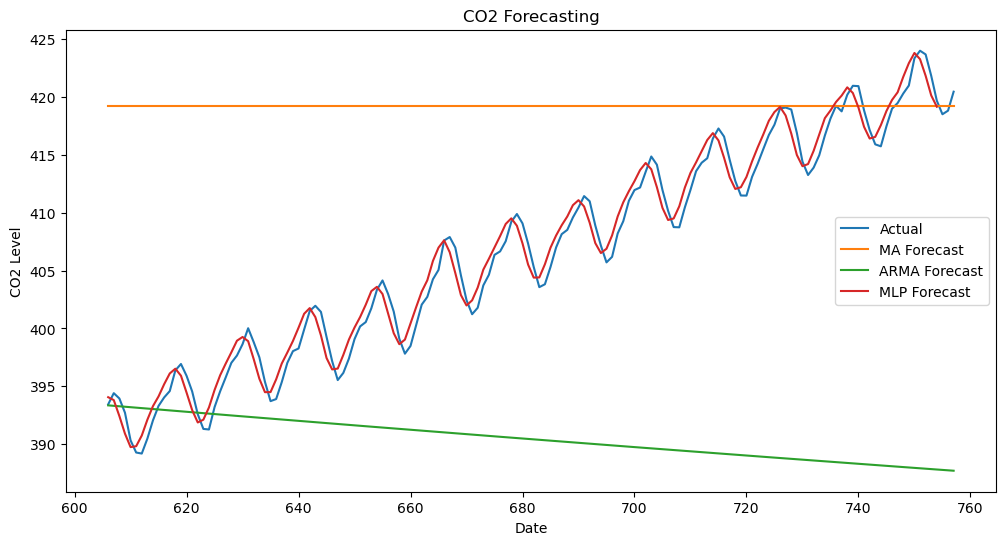

In [32]:
# Plot the actual vs forecasted values

plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['average'], label='Actual')
plt.plot(test_data.index, ma_forecast, label='MA Forecast')
plt.plot(test_data.index, arma_forecast, label='ARMA Forecast')
plt.plot(test_data.index[:len(mlp_forecast)], mlp_forecast, label='MLP Forecast')

plt.legend()
plt.title('CO2 Forecasting')
plt.xlabel('Date')
plt.ylabel('CO2 Level')
plt.show()
